# MW-M31 Merger including more galaxies

This corresponds to part 2.1 and 2.2 of the report

## Imports

In [152]:
#Math librairies
import numpy as np
from tqdm import tqdm
from scipy.interpolate import CubicSpline
import math
''
#Astro libraries
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric

from astropy import coordinates as coord

from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
cosmo = cosmology.setCosmology('planck18') 
print (cosmo.h)

#Plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

0.6766


#### The following units are used :

    - velocity: km/s
    - distance: kpc
    - mass: 10**10 Msun
    - time: Gyr

## Simulation parameters

In [153]:
#Time parameters
t         = 0      # current time of the simulation

tEnd      = 12  # time at which simulation ends (Gyr)
dt        = .01    # timestep

T=np.linspace(t, tEnd, int(tEnd / dt) +1) #list contaning all time values
T=np.array(T)

#Hernquist softening length (kpc)
softening = 17

G = 43007 # Gravitational constant in appropriate units

## Cinematics functions

In [154]:
def getAcc(pos, mass, G, softening ):
    """
    Calculate the acceleration on each particle due to Newton's Law 
    pos  is an N x 3 matrix of positions
    mass is an N x 1 vector of masses
    a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

    return a

In [155]:
def DynamicalFriction(pos, mass, vel, con,  G):
    N = len(mass)
    friction = np.zeros((N,3), dtype='float')
    
    # Precompute scale radii and host profiles
    r_s_values = np.zeros(N)
    rho_values = np.zeros(N)
    sigma_values = np.zeros(N)
    epsilon_values = np.zeros(N)
    for i in range(N):
        if mass[i] > 0:
            
            r_s_values[i] = profile_nfw.NFWProfile.nativeParameters(M=mass[i] * 1.e10 * cosmo.h, c=10.0, z=0.0, mdef='200c')[1]/cosmo.h
            if r_s_values[i] > 8.0:   # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                epsilon_values[i] = 2.2 * r_s_values[i] - 14
            else:
                epsilon_values[i] = 0.45 * r_s_values[i]
    
            r_s = r_s_values[i]
            for j in range(N):
                if (i != j) and mass[i] > 0 and mass[j] > 0 and mass[j] > mass[i]:
                    dr = pos[i] - pos[j]
                    r = np.linalg.norm(dr)
                
                    
                    if r < r_s_values[j]*10.0:  # this can be changed to r_200 later, but should be close
                        if rho_values[j] == 0:
                            profile_host = profile_nfw.NFWProfile(M=mass[j] * 1.e10 * cosmo.h, c=con[i], z=0.0, mdef='200c') # this assumes mass in solar masses
                            rho_values[j] = profile_host.density(r * cosmo.h) / 1.e10 * cosmo.h**2
                            v_max = profile_host.Vmax()[0]
                            sigma_values[j] = v_max * 1.4393 * (r / r_s)**0.354 / (1 + 1.1756 * (r / r_s)**0.725)
                        
                        rho = rho_values[j]
                        sigma = sigma_values[j]
                    
                        
                        dv = vel[i] - vel[j]
                        v = np.linalg.norm(dv)
                        x = v / np.sqrt(2 * sigma**2)
                        gamma = r / epsilon_values[i]
                        
                        fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho / max(v, 50)**3 * (math.erf(x) - 2 * x * math.exp(-x**2) / np.sqrt(np.pi))
                        friction[i] -= dv * fricmag * mass[j] / (mass[i] + mass[j])
                        friction[j] += dv * fricmag * mass[i] / (mass[i] + mass[j])
    return friction


# Adding galaxies functions

In [156]:
def get_galaxy_coordinates(Galaxy, d_mod, pm_ra_cosdec, pm_dec, vr, mass, con):
    
    coo=(SkyCoord.from_name(Galaxy))
    sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=Distance(distmod=d_mod*u.mag),pm_ra_cosdec=pm_ra_cosdec,pm_dec=pm_dec,radial_velocity=vr)

    gal=sky.transform_to(Galactocentric()) #convert ICRS coordinates to Galactocentric coordinates
    
    pos = np.array([[gal.x.value,gal.y.value,gal.z.value]]) #positions array for the concerned galaxy
    vel = np.array([[gal.v_x.value, gal.v_y.value, gal.v_z.value]]) #velocities array
    mass= np.array([[mass]])
    con=np.array([[con]])

    return pos, vel, mass, con #returns coordinates

In [157]:
def add_galaxy(positions, velocities, masses, concentrations, new_positions,new_velocities,new_masses, new_concentrations):  #add one galaxy to the array
    
    positions=np.concatenate((positions,new_positions),axis=0)
    velocities=np.concatenate((velocities,new_velocities),axis=0)
    masses=np.concatenate((masses,new_masses))
    concentrations =np.concatenate((concentrations, new_concentrations))
    return positions, velocities, masses, concentrations

## Galaxies parameters

In [158]:
# Milky Way
m_MW_mean = 100          # exctracted from [Sawala, Teeraiho 2019]
m_MW_sigma = 0.4         # uncertainties
con_MW = 7                 # concentration exctracted from [Cautun et al. 2019]

# The MW is at 0 in the galactocentric coordinate system.

# M31
m_M31_mean = 230          # exctracted from [Sawala, Teeriaho 2023]
m_M31_sigma = 100

dmod_M31_mean = 24.45    # extracted from [De Grisj, July 2014]
dmod_M31_sigma = 0.10

pm_ra_cosdec_M31_mean = 65*u.uas/u.yr #exctracted from [Van der Marel, 2019]
pm_ra_cosdec_M31_sigma = 18*u.uas/u.yr

pm_dec_M31_mean = -57*u.uas/u.yr
pm_dec_M31_sigma = 15*u.uas/u.yr 


pm_ra_cosdec_M31_mean = 48.9*u.uas/u.yr #exctracted from [Salomon, 2021]
pm_ra_cosdec_M31_sigma = 10.5*u.uas/u.yr

pm_dec_M31_mean = -36.9*u.uas/u.yr
pm_dec_M31_sigma = 8.1*u.uas/u.yr 


# pm_ra_cosdec_M31_mean = 45*u.uas/u.yr #exctracted from [Van der Marel, 2012]
# pm_ra_cosdec_M31_sigma = 18*u.uas/u.yr

# pm_dec_M31_mean = -32*u.uas/u.yr
# pm_dec_M31_sigma = 15*u.uas/u.yr 


vr_M31_mean = -301*u.km/u.s #exctracted from [Karachentsev 2006]
vr_M31_sigma = 1*u.km/u.s

con_M31 = 7                 # concentration exctracted from [Cautun et al. 2019]


# M33
m_M33_mean= 15 # exctracted from [Van der Marel 2012]
m_M33_sigma= 2 # Reference needed

dmod_M33_mean = 24.67 #pm 0.07
dmod_M33_sigma = 0.07

pm_ra_cosdec_M33_mean = 31 *u.uas/u.yr #exctracted from [Van der Marel, 2019]
pm_ra_cosdec_M33_sigma = 19 *u.uas/u.yr 

pm_dec_M33_mean = -29 *u.uas/u.yr
pm_dec_M33_sigma = 16 *u.uas/u.yr

vr_M33_mean = -179.2 *u.km/u.s # exctracted from Simbad Univ Strasbourg
vr_M33_sigma = 3*u.km/u.s

con_M33 = 6                 # ref needed


# LMC
m_LMC_mean = 25  #exctracted from [Erkal, Denis 2019]
m_LMC_sigma = 2.6

dmod_LMC_mean = 18.477
dmod_LMC_sigma = 0.026

pm_ra_cosdec_LMC_mean = 1.910 *u.mas/u.yr #exctracted from [Kallivayalil, 2013]
pm_ra_cosdec_LMC_sigma = 0.020*u.mas/u.yr

pm_dec_LMC_mean = 0.229*u.mas/u.yr
pm_dec_LMC_sigma = 0.047 *u.mas/u.yr

vr_LMC_mean = 262.2*u.km/u.s
vr_LMC_sigma=3.4*u.km/u.s

con_LMC = 8                 # concentration exctracted from [Cautun et al. 2019]

## Create galactocentric coordinates and velocities

In [159]:
# Initial conditions for the Milky Way

pos_MW = np.array([[0.,0.,0.]])
vel_MW =  np.array([[0.,0.,0.]])
mass_MW = np.array([[m_MW_mean]])
con_MW = np.array([[con_MW]])

#Get galactocentric coordinates and velocities

pos_M31, vel_M31, mass_M31, con_M31 = get_galaxy_coordinates('M31', dmod_M31_mean, pm_ra_cosdec_M31_mean, pm_dec_M31_mean, vr_M31_mean, m_M31_mean, con_M31)
pos_M33, vel_M33, mass_M33, con_M33 = get_galaxy_coordinates('M33', dmod_M33_mean, pm_ra_cosdec_M33_mean, pm_dec_M33_mean, vr_M33_mean, m_M33_mean, con_M33)
pos_LMC, vel_LMC, mass_LMC, con_LMC = get_galaxy_coordinates('LMC', dmod_LMC_mean, pm_ra_cosdec_LMC_mean, pm_dec_LMC_mean, vr_LMC_mean, m_LMC_mean, con_LMC)

v: [ -39.1219049  -216.78854361  215.45562392]
x:  [  -0.67990983  -40.94993054  -26.92651431]

## Create the initial conditions by adding galaxies to the system

In [160]:
positions, velocities, masses, concentrations = add_galaxy(pos_MW, vel_MW, mass_MW, con_MW, pos_M31, vel_M31, mass_M31, con_M31)
positions, velocities, masses, concentrations = add_galaxy(positions, velocities, masses, concentrations, pos_M33, vel_M33, mass_M33, con_M33)
positions, velocities, masses, concentrations = add_galaxy(positions, velocities, masses, concentrations, pos_LMC, vel_LMC, mass_LMC, con_LMC)

### Number of Galaxies :

In [161]:
N  = len(masses)
print ("N:", N)

N: 4


### Test dynamical friction

<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\3391799639.py:27: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Density ($M_\odot\ h^2 /kpc^3$)')


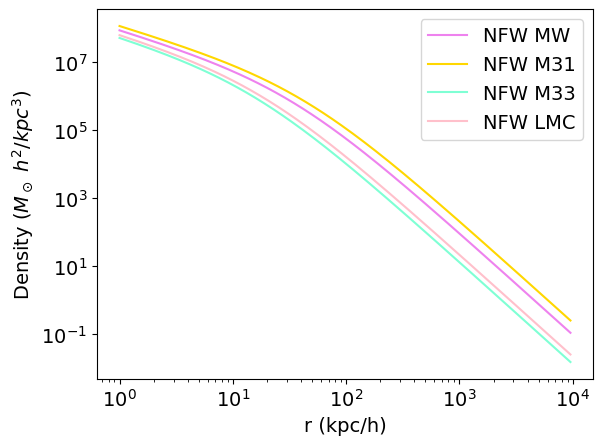

In [162]:
#Density plot


#M=mass, c=concentration, z=redshif, mdef = mass definition in which M and c are given.
plt.rcParams.update({'font.size':14})

p_nfw_MW = profile_nfw.NFWProfile(M = (m_MW_mean*10**10*u.Msun/cosmo.h).value, c = 7.0, z = 0.0, mdef = 'vir')
p_nfw_M31 = profile_nfw.NFWProfile(M = (m_M31_mean*10**10*u.Msun/cosmo.h).value, c = 7.0, z = 0.0, mdef = 'vir')
p_nfw_M33 = profile_nfw.NFWProfile(M = (m_M33_mean*10**10*u.Msun/cosmo.h).value, c = 8.0, z = 0.0, mdef = 'vir')
p_nfw_LMC = profile_nfw.NFWProfile(M = (m_LMC_mean*10**10*u.Msun/cosmo.h).value, c = 8.0, z = 0.0, mdef = 'vir')

r = 10**np.arange(0,4,0.02)

rho_nfw_MW = p_nfw_MW.density(r)
rho_nfw_M31 = p_nfw_M31.density(r)
rho_nfw_M33 = p_nfw_M33.density(r)
rho_nfw_LMC = p_nfw_LMC.density(r)

fig, ax =plt.subplots()

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)
plt.rcParams.update({'font.size':14})

plt.loglog()
plt.xlabel('r (kpc/h)')
plt.ylabel('Density ($M_\odot\ h^2 /kpc^3$)')
plt.plot(r, rho_nfw_MW, '-', label = 'NFW MW', color='violet')
plt.plot(r, rho_nfw_M31, '-', label = 'NFW M31', color = 'gold')
plt.plot(r, rho_nfw_M33, '-', label = 'NFW M33', color = 'aquamarine')
plt.plot(r, rho_nfw_LMC, '-', label = 'NFW LMC', color = 'pink')
plt.legend()
plt.savefig('demo.png', transparent=True)
plt.show()

In [163]:
print ("Acceleration):\n", getAcc( positions, masses, G, softening ))
print ("velocities:\n", velocities)
print ("DynamicalFriction(positions, masses, velocities, concentrations, G, N):\n", DynamicalFriction(positions, masses, velocities, concentrations, G))
velocities_cm = velocities - np.mean(masses * velocities,0) / np.mean(masses)
print ("velocities (CM):\n", velocities_cm)
print ("DynamicalFriction (cm) (positions, masses, velocities_cm, concentrations,  G, N):\n", DynamicalFriction(positions, masses, velocities_cm, concentrations, G))

Acceleration):
 [[ -13.3058364  -301.95539789 -213.71756613]
 [  -3.12659808  -11.74902816   -5.83034136]
 [ 117.4003704    69.08924797  140.67934091]
 [  11.5478257  1274.45910189  824.10180049]]
velocities:
 [[   0.            0.            0.        ]
 [  35.17495298 -129.1695278   -13.86820585]
 [  45.30797746   -0.82536079   22.54752995]
 [ -37.29298305 -225.90831136  227.81723526]]
DynamicalFriction(positions, masses, velocities, concentrations, G, N):
 [[ -3.25593014 -19.72332649  19.88998849]
 [  0.17466387   2.21228009   0.62770135]
 [ -2.67817926 -33.92162798  -9.62475406]
 [ 13.02372057  78.89330597 -79.55995394]]
velocities (CM):
 [[ -21.18252506   95.592107     -7.68636888]
 [  13.99242792  -33.5774208   -21.55457473]
 [  24.12545241   94.76674621   14.86116107]
 [ -58.47550811 -130.31620436  220.13086638]]
DynamicalFriction (cm) (positions, masses, velocities_cm, concentrations,  G, N):
 [[ -3.25593014 -19.72332649  19.88998849]
 [  0.17466387   2.21228009   0.62770135]
 

C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_s_values[i] = profile_nfw.NFWProfile.nativeParameters(M=mass[i] * 1.e10 * cosmo.h, c=10.0, z=0.0, mdef='200c')[1]/cosmo.h
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rho_values[j] = profile_host.density(r * cosmo.h) / 1.e10 * cosmo.h**2
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your

# Orbit integration

In [164]:

# Convert to Center-of-Mass frame
velocities -= np.mean(masses * velocities,0) / np.mean(masses)

# calculate initial gravitational accelerations

acc = getAcc( positions, masses, G, softening )
fric = DynamicalFriction(positions, masses, velocities, concentrations, G)


# number of timesteps
Nt = int(np.ceil(tEnd/dt))

print ("Nt:", Nt)

# save particle orbits for plotting trails
pos_save = np.zeros((N,3,Nt+1))

exists_save = np.ones((N,Nt+1))

pos_save[:,:,0] = positions

vel_save = np.zeros((N,3,Nt+1))
vel_save[:,:,0] = velocities     
t_all = np.arange(Nt+1)*dt

acc_save = np.zeros((N,Nt+1))
fric_save = np.zeros((N,Nt+1))


acc_save[:,0] = np.linalg.norm(acc, axis=1)
fric_save[:,0] = np.linalg.norm(fric, axis=1)

t=0

# Simulation Main Loop = Leapfrog integration for N galaxies 
#   00   *ribbit*
#  (--)
# ( || )
# ^^~~^^

for i in range(Nt):
    
    # (1/2) kick
    velocities += (acc + fric) * dt /2.0

    # drift
    positions += velocities * dt

    # update accelerations
    acc = getAcc( positions, masses, G, softening )

    # update dynamical friction
    fric = DynamicalFriction(positions, masses, velocities, concentrations, G)
    
    # (1/2) kick
    velocities += (acc + fric) * dt/2.0

    # update time
    t += dt

    # save positions for plotting trail
    pos_save[:,:,i+1] = positions
    acc_save[:,i+1] = np.linalg.norm(acc, axis=1)
    fric_save[:,i+1] = np.linalg.norm(fric, axis=1)

    for l in range(N):
        for m in range(N):

            if l != m :
                if np.linalg.norm(positions[l,:]-positions[m,:], axis=0) < 10 :

                    if masses[l] > masses[m] :
                        remove = m
                        keep = l
                    else:
                        remove = l
                        keep = m

                    if exists_save[remove,i] > 0:

                        print('Galaxy '+str(remove)+' has merged with galaxy '+ str(keep) +' at',t,'Gyr')
                        positions[keep] = (masses[keep] * positions[keep] + masses[remove] * positions[remove] ) / (masses[keep] + masses[remove] )
                        velocities[keep] = (masses[keep] * velocities[keep] + masses[remove] * velocities[remove] ) / (masses[keep] + masses[remove] )

                        masses[keep]=masses[keep]+masses[remove]
                        masses[remove]=[0]
                        exists_save[remove,i:-1] = 0

xx = pos_save[:,0,:]
yy = pos_save[:,1,:]
zz = pos_save[:,2,:]

Nt: 1200


C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_s_values[i] = profile_nfw.NFWProfile.nativeParameters(M=mass[i] * 1.e10 * cosmo.h, c=10.0, z=0.0, mdef='200c')[1]/cosmo.h
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rho_values[j] = profile_host.density(r * cosmo.h) / 1.e10 * cosmo.h**2
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your

Galaxy 3 has merged with galaxy 0 at 1.350000000000001 Gyr
Galaxy 2 has merged with galaxy 1 at 3.2999999999999736 Gyr


In [165]:
#Now Calculating impact parameter

r_M31 = np.linalg.norm(pos_save[1,:,:]-pos_save[0,:,:],axis=0)
times_MW = np.where(exists_save[0,:-1] > 0)[0]
times_M31 = np.where(exists_save[1,:-1] > 0)[0]

if N> 2 :
    r_M33 = np.linalg.norm(pos_save[2,:,:]-pos_save[0,:,:],axis=0)
    r_LMC = np.linalg.norm(pos_save[3,:,:]-pos_save[0,:,:],axis=0)
    r_M33_M31 = np.linalg.norm(pos_save[2,:,:]-pos_save[1,:,:],axis=0)


    times_M33 = np.where(exists_save[2,:-1] > 0)[0]
    times_LMC = np.where(exists_save[3,:-1] > 0)[0]

b=min(r_M31)
t=np.argmin(r_M31)*dt

print('b=', b)
print('t=',t)

b= 149.17229844015884
t= 5.43


### Velocities Check

In [166]:
v=np.dot((vel_save[0,:,0] - vel_save[1,:,0]), (vel_save[0,:,0] - vel_save[1,:,0]))**.5
print('Total velocity=', v)

vr=np.dot((vel_save[0,:,0]-vel_save[1,:,0]),(pos_save[0,:,0]-pos_save[1,:,0]))/r_M31[0]
print('Radial velocity=', vr)

vt = (v**2-vr**2)**(1/2)
print('Transverse velocity=', vt)


Total velocity= 134.58964061821624
Radial velocity= -114.44583236676522
Transverse velocity= 70.82741570620009


## Plotting the orbits

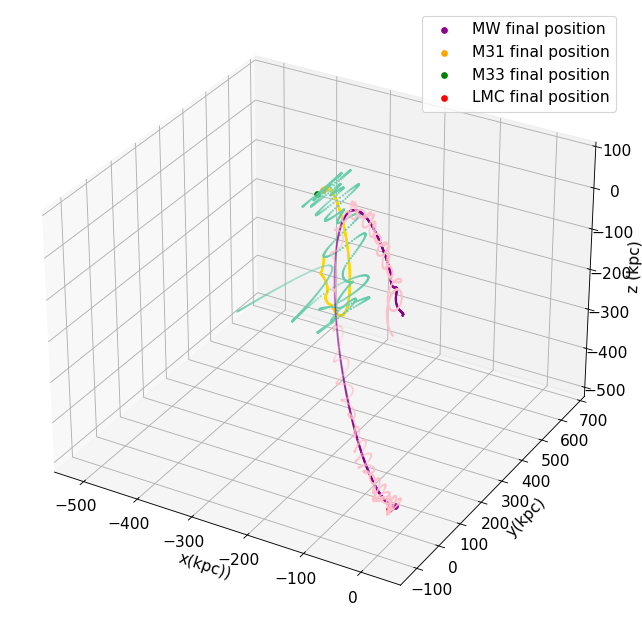

In [167]:

fig = plt.figure(figsize=(10,10), dpi=80)
ax = plt.axes(projection='3d')
plt.rcParams.update({'font.size':14})

labels = ["MW final position", "M31 final position", "M33 final position","LMC final position"]
trace_colors=['darkmagenta','gold','mediumaquamarine','pink']
colors=['darkmagenta','orange','green','red']

for i in range (N):
        ax.scatter(positions[i,0],positions[i,1], positions[i,2],s=25,label=labels[i], color=colors[i])
        ax.scatter(pos_save[i,0,:],pos_save[i,1,:],pos_save[i,2,:],s=1,color=trace_colors[i])
        
ax.set_xlabel("x(kpc))")
ax.set_ylabel("y(kpc)")
ax.set_zlabel("z (kpc)")
ax.legend(loc="best")

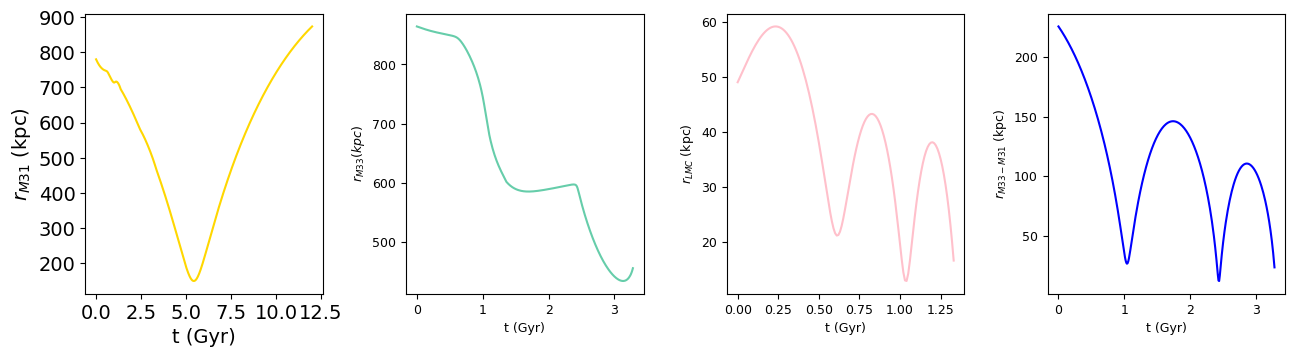

In [168]:
plt.figure(figsize = (15, 4)) 
plt.rcParams.update({'font.size':14})
plt.rcParams.update({'font.size':9})
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

plt.rcParams.update({'font.size':14})

plt.subplot(1,4,1)
plt.plot(t_all,r_M31,color='gold')
plt.xlabel('t (Gyr)')
plt.ylabel('$r_{M31}$ (kpc)')

plt.rcParams.update({'font.size':9})
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'


if N> 2 :
    plt.subplot(1,4,2)
    plt.plot(t_all[times_M33],r_M33[times_M33],color='mediumaquamarine')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$r_{M33} (kpc) $')

    plt.subplot(1,4,3)
    plt.plot(t_all[times_LMC],r_LMC[times_LMC],color='pink')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$r_{LMC}$ (kpc)')

    plt.subplot(1,4,4)
    plt.plot(t_all[times_M33],r_M33_M31[times_M33],color='blue')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$r_{M33-M31}$ (kpc)')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.35, hspace=0.4)

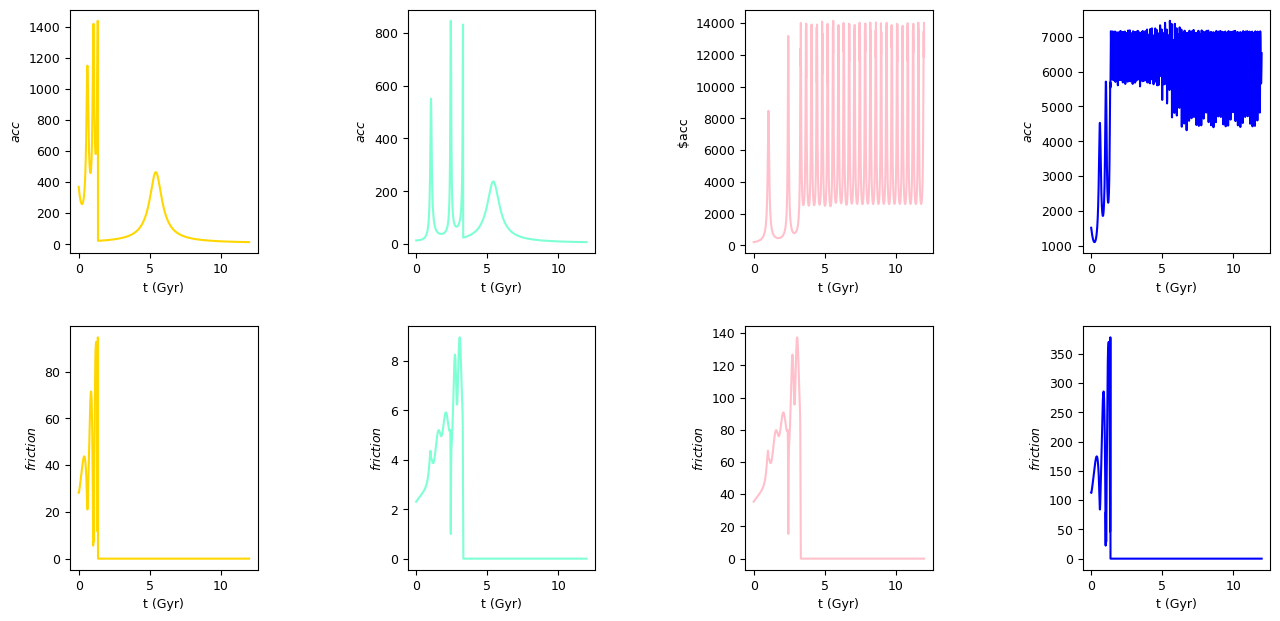

In [169]:
if N>2:

    plt.figure(figsize = (15, 8)) 

    plt.subplot(2,4,1)
    plt.plot(t_all,acc_save[0,:],color='gold')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$acc$')

    plt.subplot(2,4,2)
    plt.plot(t_all,acc_save[1,:],color='aquamarine')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$acc$')

    plt.subplot(2,4,3)
    plt.plot(t_all,acc_save[2,:],color='pink')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$acc')

    plt.subplot(2,4,4)
    plt.plot(t_all,acc_save[3,:],color='blue')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$acc$')

    plt.subplot(2,4,5)
    plt.plot(t_all,fric_save[0,:],color='gold')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$friction$')

    plt.subplot(2,4,6)
    plt.plot(t_all,fric_save[1,:],color='aquamarine')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$friction$')

    plt.subplot(2,4,7)
    plt.plot(t_all,fric_save[2,:],color='pink')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$friction$')

    plt.subplot(2,4,8)
    plt.plot(t_all,fric_save[3,:],color='blue')
    plt.xlabel('t (Gyr)')
    plt.ylabel('$friction$')


    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.8, hspace=0.3)

# Orbit calculation with initial conditions variation

## Statistics function

In [170]:
def print_variable(variable):
    variable_name = [name for name, value in globals().items() if value is variable][0]
    print(f"Variable: {variable_name}")


def statistics(name) :
    print('-------------------------------------------------------------------------------------------')
    print_variable(name)
    print('mean=', np.mean(name))
    print('median=',np.median(name))
    print('standard deviation=',np.std(name))
    print('-1 sigma=',np.median(name) - np.percentile(name, 15.8))
    print('1 sigma=', np.percentile(name, 84.5) - np.median(name))

## Calculating impact parameter and time function

In [171]:
print (positions)
print(velocities)
print(masses)

[[  28.31989871  -97.05827144 -390.79781388]
 [-387.63024538  624.24040859 -125.85270299]
 [-398.03606416  625.85612657 -141.60881784]
 [  24.42375668 -113.87722482 -389.96932148]]
[[  26.54113332  -41.19935519   34.44478251]
 [ -11.59000052   17.24233494  -19.99861475]
 [-348.18567333  385.15301506 -524.34353483]
 [  77.49202801  169.06983709  146.26191998]]
[[125]
 [245]
 [  0]
 [  0]]


In [172]:
def calculate_B_and_t(t,positions,velocities,masses, concentrations, N_values) :

    blist=[]
    tlist=[]
    vlist=[]
    vrlist=[]
    vtlist=[]
    times_LMC_list=[]
    times_M33_list=[]
    
    # masses should be an array of shape [N, N_values]
    masses = np.resize(masses, (N, N_values)) 

    # positions should be an array of shape [N, 3, N_values]
    
    for j in tqdm (range (N_values), ascii='▖▘▝▗▚▞█'):
        
        mass = masses[:,j]
        mass = mass.reshape(N,1)


        pos = positions[:,:,j]
        vel = velocities[:,:,j]

        # Convert to Center-of-Mass frame

        vel -= np.mean(mass* vel,0) / np.mean(mass)
        mass = np.resize(mass, (N,1))

        # calculate initial gravitational accelerations
        
        acc = getAcc( pos, mass, G, softening )
       
        fric = DynamicalFriction(pos, mass, vel, concentrations, G)
       
        
        # number of timesteps
        Nt = int(np.ceil( (tEnd) /dt))

        # save energies, particle orbits for plotting trails
        pos_save = np.zeros((N,3,Nt+1))
        pos_save[:,:,0] = pos
        vel_save = np.zeros((N,3,Nt+1))
        vel_save[:,:,0] = vel     
        t_all = np.arange(Nt+1)*dt

        t = 0

        # Simulation Main Loop = Leapfrog integration for N galaxies 
        #   00   *ribbit*
        #  (--)
        # ( || )
        # ^^~~^^
        
        for i in range(Nt):
            # (1/2) kick
            vel+= (acc + fric) * dt /2.0

            # drift
            pos += vel * dt

            # update accelerations
            acc = getAcc( pos, mass, G, softening )

            # calculate dynamical friction
            fric = DynamicalFriction(pos, mass, vel, concentrations, G)
           

            # (1/2) kick
            vel += (acc + fric) * dt/2.0

            # update time
            t += dt

            # save positions for plotting trail
            pos_save[:,:,i+1] = pos
          
            acc_save[:,i+1] = np.linalg.norm(acc, axis=1)
            fric_save[:,i+1] = np.linalg.norm(fric, axis=1)

            for l in range(N):
                for m in range(N):

                    if l != m :
                        if np.linalg.norm(pos[l,:]-pos[m,:], axis=0) < 10 :

                            if mass[l] > mass[m] :
                                remove = m
                                keep = l
                            else:
                                remove = l
                                keep = m

                            if exists_save[remove,i] > 0:

                                print('Galaxy '+str(remove)+' has merged with galaxy '+ str(keep) +' at',t,'Gyr')
                                pos[keep] = (mass[keep] * pos[keep] + mass[remove] * pos[remove] ) / (mass[keep] + mass[remove] )
                                vel[keep] = (mass[keep] * vel[keep] + mass[remove] * vel[remove] ) / (mass[keep] + mass[remove] )

                                masses[keep]=masses[keep]+masses[remove]
                                masses[remove]=[0]
                                exists_save[remove,i:-1] = 0

        xx = pos_save[:,0,:]
        yy = pos_save[:,1,:]
        zz = pos_save[:,2,:]


        #Now Calculating impact parameter
      
        r_M31 = np.linalg.norm(pos_save[1,:,:]-pos_save[0,:,:],axis=0)
        times_MW = np.where(exists_save[0,:-1] > 0)[0]
        times_M31 = np.where(exists_save[1,:-1] > 0)[0]

        if N> 2:
            r_M33 = np.linalg.norm(pos_save[2,:,:]-pos_save[0,:,:],axis=0)
            r_LMC = np.linalg.norm(pos_save[3,:,:]-pos_save[0,:,:],axis=0)
            r_M33_M31 = np.linalg.norm(pos_save[2,:,:]-pos_save[1,:,:],axis=0)



        b=min(r_M31)
        t=np.argmin(r_M31)*dt

        #Interpolation for more precision
        f = CubicSpline(T,r_M31,bc_type='natural')
        timesteps=1000
        T_new=np.linspace(t-dt,t+dt,timesteps)

        r_new=f(T_new)
        b=min(r_new)
        t= t - dt + np.argmin(r_new)*(2*dt / timesteps)
        
        blist.append(b)
        tlist.append(t)

        #Velocities

        v=np.dot((vel_save[0,:,0] - vel_save[1,:,0]), (vel_save[0,:,0] - vel_save[1,:,0]))**.5
        vlist.append(v)
       
        vr=np.dot((vel_save[0,:,0]-vel_save[1,:,0]),(pos_save[0,:,0]-pos_save[1,:,0]))/r_M31[0]
        vrlist.append(vr)

        vt = (v**2-vr**2)**(1/2)
        vtlist.append(vt)
    
    barray=np.array(blist)
    tarray=np.array(tlist)
    varray=np.array(vlist)
    vrarray=np.array(vrlist)
    vtarray=np.array(vtlist)
 
    return barray, tarray, varray, vrarray, vtarray

## Initial conditions variation

In [173]:
#Number of variations wished 
N_values=1000

In [174]:
#Milky Way
  
x= np.zeros(N_values)      
y= np.zeros(N_values)       
z= np.zeros(N_values)       
vx= np.zeros(N_values)   
vy= np.zeros(N_values)      
vz= np.zeros(N_values) 

m_MW= np.abs(np.random.normal(m_MW_mean,m_MW_sigma,N_values))

#Vectors containing the values of initial conditions
positions = np.array([[x,y,z]])
velocities =  np.array([[vx,vy,vz]])
masses = np.array([[m_MW]])
concentrations = np.array([[con_MW]])

In [175]:
#M31

dmod_M31=np.random.normal(dmod_M31_mean,dmod_M31_sigma,N_values)
               
pm_ra_cosdec_M31=np.random.normal(pm_ra_cosdec_M31_mean.value,pm_ra_cosdec_M31_sigma.value,N_values)
pm_ra_cosdec_M31=pm_ra_cosdec_M31*u.uas/u.yr

pm_dec_M31=np.random.normal(pm_dec_M31_mean.value,pm_dec_M31_sigma.value,N_values)
pm_dec_M31=pm_dec_M31*u.uas/u.yr

vr_M31=np.random.normal(vr_M31_mean.value,vr_M31_sigma.value,N_values)
vr_M31=vr_M31*u.km/u.s

m_M31= np.abs(np.random.normal(m_M31_mean,m_M31_sigma,N_values))


#M33

dmod_M33=np.random.normal(dmod_M33_mean,dmod_M33_sigma,N_values)
               
pm_ra_cosdec_M33=np.random.normal(pm_ra_cosdec_M33_mean.value,pm_ra_cosdec_M33_sigma.value,N_values)
pm_ra_cosdec_M33=pm_ra_cosdec_M33*u.uas/u.yr

pm_dec_M33=np.random.normal(pm_dec_M33_mean.value,pm_dec_M33_sigma.value,N_values)
pm_dec_M33=pm_dec_M33*u.uas/u.yr

vr_M33=np.random.normal(vr_M33_mean.value,vr_M33_sigma.value,N_values)
vr_M33=vr_M33*u.km/u.s

m_M33= np.abs(np.random.normal(m_M33_mean,m_M33_sigma,N_values))

#LMC

dmod_LMC=np.random.normal(dmod_LMC_mean,dmod_LMC_sigma,N_values)
               
pm_ra_cosdec_LMC=np.random.normal(pm_ra_cosdec_LMC_mean.value,pm_ra_cosdec_LMC_sigma.value,N_values)
pm_ra_cosdec_LMC=pm_ra_cosdec_LMC*u.mas/u.yr

pm_dec_LMC=np.random.normal(pm_dec_LMC_mean.value,pm_dec_LMC_sigma.value,N_values)
pm_dec_LMC=pm_dec_LMC*u.mas/u.yr

vr_LMC=np.random.normal(vr_LMC_mean.value,vr_LMC_sigma.value,N_values)
vr_LMC=vr_LMC*u.km/u.s

m_LMC= np.abs(np.random.normal(m_LMC_mean,m_LMC_sigma,N_values))


In [176]:
#Get galactocentric coordinates from astropy
pos_M31, vel_M31, mass_M31, con_M31 = get_galaxy_coordinates('M31', dmod_M31, pm_ra_cosdec_M31, pm_dec_M31, vr_M31, m_M31, con_M31)
pos_M33, vel_M33, mass_M33, con_M33 = get_galaxy_coordinates('M33', dmod_M33, pm_ra_cosdec_M33, pm_dec_M33, vr_M33, m_M33, con_M33)
pos_LMC, vel_LMC, mass_LMC, con_LMC= get_galaxy_coordinates('LMC', dmod_LMC, pm_ra_cosdec_LMC, pm_dec_LMC, vr_LMC, m_LMC, con_LMC) 


### Adding Galaxies to the system

In [177]:
positions, velocities, masses, concentrations = add_galaxy(positions, velocities, masses, concentrations, pos_M31, vel_M31, mass_M31, con_M31)
positions, velocities, masses, concentrations = add_galaxy(positions, velocities, masses, concentrations, pos_M33, vel_M33, mass_M33, con_M33)
positions, velocities, masses, concentrations = add_galaxy(positions, velocities, masses, concentrations, pos_LMC, vel_LMC, mass_LMC, con_LMC)

In [178]:
print (positions)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-3.94397945e+02 -3.93577563e+02 -3.66729645e+02 ... -3.41417937e+02
   -3.88596746e+02 -3.87465893e+02]
  [ 6.37220930e+02  6.35867585e+02  5.91577864e+02 ...  5.49822354e+02
    6.27650971e+02  6.25785457e+02]
  [-2.93463524e+02 -2.92840215e+02 -2.72441734e+02 ... -2.53210433e+02
   -2.89055896e+02 -2.88196697e+02]]

 [[-4.98641496e+02 -5.25611436e+02 -5.37781012e+02 ... -4.91289838e+02
   -4.82175292e+02 -5.05740642e+02]
  [ 5.13755500e+02  5.42003010e+02  5.54749060e+02 ...  5.06055593e+02
    4.96509290e+02  5.21190933e+02]
  [-4.30662563e+02 -4.54342568e+02 -4.65027634e+02 ... -4.24207699e+02
   -4.16204994e+02 -4.36895717e+02]]

 [[-5.73924525e-01 -5.26822008e

## Calculations of impact parameter and time

In [179]:
var_B, var_t, var_v, var_vr, var_vt, =calculate_B_and_t(t,positions,velocities,masses, concentrations, N_values)

  0%|▖▖▖▖▖▖▖▖▖▖| 0/1000 [00:00<?, ?it/s]C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_s_values[i] = profile_nfw.NFWProfile.nativeParameters(M=mass[i] * 1.e10 * cosmo.h, c=10.0, z=0.0, mdef='200c')[1]/cosmo.h
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rho_values[j] = profile_host.density(r * cosmo.h) / 1.e10 * cosmo.h**2
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\4198699415.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensur

Galaxy 2 has merged with galaxy 1 at 3.1599999999999766 Gyr


  1%|▖▖▖▖▖▖▖▖▖▖| 6/1000 [00:06<16:28,  1.01it/s]

Galaxy 3 has merged with galaxy 0 at 1.330000000000001 Gyr


  4%|▝▖▖▖▖▖▖▖▖▖| 41/1000 [00:28<10:33,  1.51it/s]

Galaxy 2 has merged with galaxy 1 at 3.1099999999999777 Gyr


  4%|▝▖▖▖▖▖▖▖▖▖| 43/1000 [00:29<10:17,  1.55it/s]

Galaxy 2 has merged with galaxy 1 at 2.6399999999999877 Gyr


  6%|▗▖▖▖▖▖▖▖▖▖| 61/1000 [00:40<08:57,  1.75it/s]

Galaxy 1 has merged with galaxy 0 at 6.559999999999905 Gyr


  7%|▚▖▖▖▖▖▖▖▖▖| 67/1000 [00:43<07:40,  2.03it/s]

Galaxy 1 has merged with galaxy 0 at 3.039999999999979 Gyr


 27%|██▚▖▖▖▖▖▖▖| 274/1000 [02:20<05:17,  2.29it/s]

Galaxy 1 has merged with galaxy 0 at 2.7899999999999845 Gyr


 34%|███▝▖▖▖▖▖▖| 335/1000 [02:48<04:53,  2.26it/s]

Galaxy 1 has merged with galaxy 0 at 2.7399999999999856 Gyr


100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s]


## Plotting  histograms of variation

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\3642796736.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{MW} (10^{10} M_{\odot}$)')
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\3642796736.py:14: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{M31} (10^{10} M_{\odot}$)')
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\3642796736.py:20: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{M33} (10^{10} M_{\odot}$)')
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\3642796736.py:26: SyntaxWarning: invalid escape sequence '\o'
  plt.xlab

-------------------------------------------------------------------------------------------
Variable: m_MW
mean= 99.95059503571785
median= 99.95537961927502
standard deviation= 0.38988373972848245
-1 sigma= 0.4192031488231436
1 sigma= 0.39104706007022116
-------------------------------------------------------------------------------------------
Variable: m_M31
mean= 232.02859683784027
median= 230.16570160183608
standard deviation= 98.47201317990285
-1 sigma= 95.46027473682764
1 sigma= 101.65050663193074
-------------------------------------------------------------------------------------------
Variable: m_M33
mean= 15.008355354379674
median= 14.937320264094186
standard deviation= 1.9530100128847503
-1 sigma= 1.794552036561246
1 sigma= 2.0526316272618246
-------------------------------------------------------------------------------------------
Variable: m_LMC
mean= 24.98358453868261
median= 24.9407913832347
standard deviation= 2.58272953094928
-1 sigma= 2.485812889144075
1 sigma= 2.678

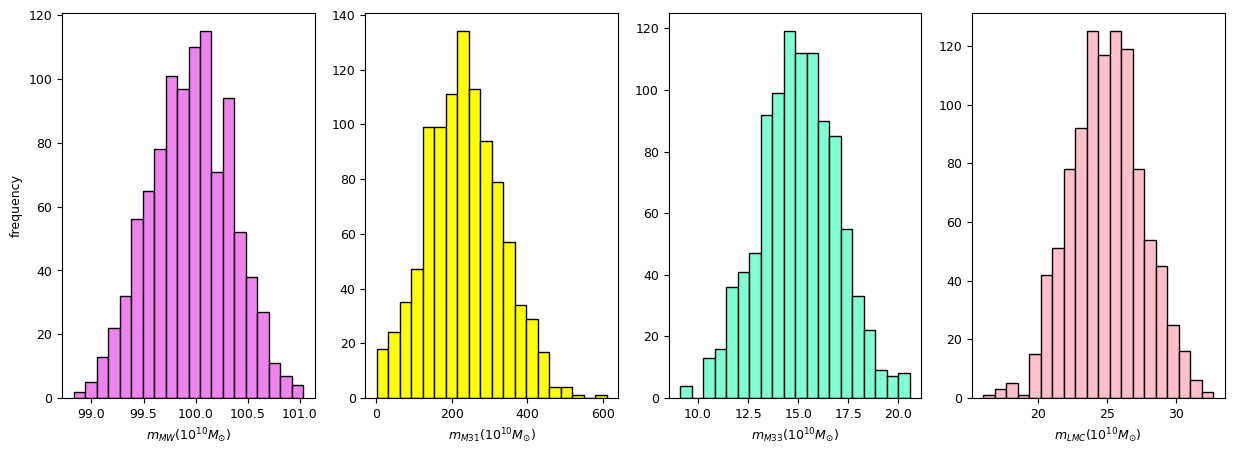

In [180]:
#Mass variations

plt.figure(figsize = (15, 5)) 

plt.subplot(1,4,1)
plt.hist(m_MW,color='violet',ec='black',bins=20)
plt.xlabel('$m_{MW} (10^{10} M_{\odot}$)')
plt.ylabel('frequency')

stat=statistics(m_MW)

plt.subplot(1,4,2)
plt.hist(m_M31,color='yellow',ec='black',bins=20)
plt.xlabel('$m_{M31} (10^{10} M_{\odot}$)')

stat=statistics(m_M31)

plt.subplot(1,4,3)
plt.hist(m_M33,color='aquamarine',ec='black',bins=20)
plt.xlabel('$m_{M33} (10^{10} M_{\odot}$)')

stat=statistics(m_M33)

plt.subplot(1,4,4)
plt.hist(m_LMC, color='pink',ec='black',bins=20)
plt.xlabel('$m_{LMC} (10^{10} M_{\odot}$)')

stat=statistics(m_LMC)

-------------------------------------------------------------------------------------------
Variable: pm_ra_cosdec_M31
mean= 48.98707577285928 uas / yr
median= 49.085963802206415 uas / yr
standard deviation= 10.376564581316895 uas / yr
-1 sigma= 10.178353972353825 uas / yr
1 sigma= 10.368831371397107 uas / yr
-------------------------------------------------------------------------------------------
Variable: pm_ra_cosdec_M33
mean= 31.014960980639778 uas / yr
median= 30.56852174397666 uas / yr
standard deviation= 18.60138594120989 uas / yr
-1 sigma= 17.852680367809896 uas / yr
1 sigma= 18.54872274459948 uas / yr
-------------------------------------------------------------------------------------------
Variable: pm_ra_cosdec_LMC
mean= 1.9091482166156175 mas / yr
median= 1.9095891112550052 mas / yr
standard deviation= 0.019597557397765752 mas / yr
-1 sigma= 0.02020091231363086 mas / yr
1 sigma= 0.01942375258347373 mas / yr


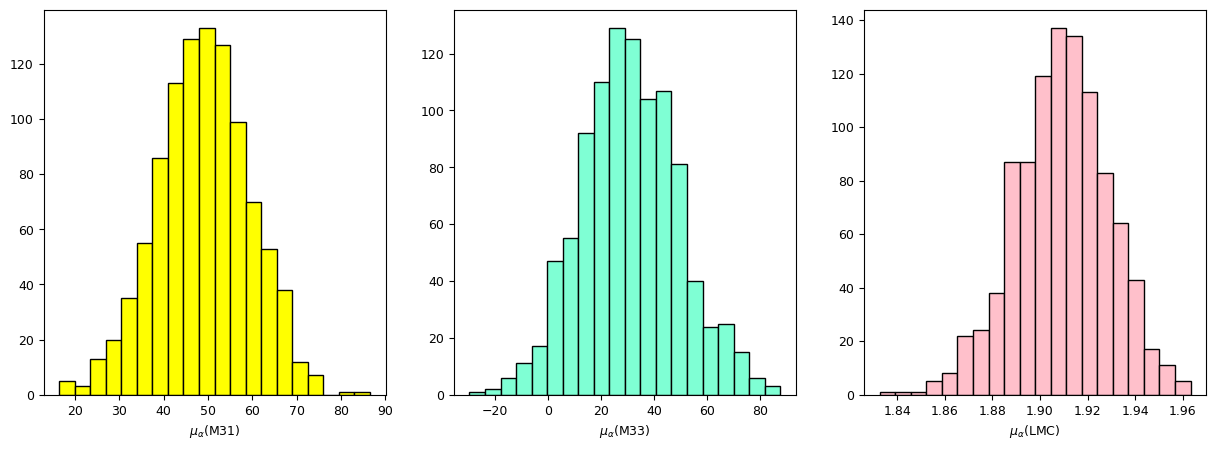

In [181]:
#Pm ra cos dec variation
plt.figure(figsize = (15, 5)) 
plt.subplot(1,3,1)
plt.hist(pm_ra_cosdec_M31.value,color='yellow',ec='black',bins=20)
plt.xlabel(r'$\mu_{\alpha}$(M31)')

stat=statistics(pm_ra_cosdec_M31)


plt.subplot(1,3,2)
plt.hist(pm_ra_cosdec_M33.value,color='aquamarine',ec='black',bins=20)
plt.xlabel(r'$\mu_{\alpha}$(M33)')

stat=statistics(pm_ra_cosdec_M33)

plt.subplot(1,3,3)
plt.hist(pm_ra_cosdec_LMC.value, color='pink',ec='black',bins=20)
plt.xlabel(r'$\mu_{\alpha}$(LMC)')

stat=statistics(pm_ra_cosdec_LMC)

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\3963005512.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu_{\delta}$(M31)')
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\3963005512.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu_{\delta}$(M33)')
C:\Users\jehan\AppData\Local\Temp\ipykernel_23376\3963005512.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu_{\delta}$(LMC)')


-------------------------------------------------------------------------------------------
Variable: pm_dec_M31
mean= -36.810625822300395 uas / yr
median= -37.07336673693372 uas / yr
standard deviation= 8.086077940937503 uas / yr
-1 sigma= 7.644416299543536 uas / yr
1 sigma= 8.357321103123297 uas / yr
-------------------------------------------------------------------------------------------
Variable: pm_dec_M33
mean= -29.256298342000242 uas / yr
median= -29.284695772515317 uas / yr
standard deviation= 15.181336309996428 uas / yr
-1 sigma= 15.3438055525877 uas / yr
1 sigma= 16.0622233239946 uas / yr
-------------------------------------------------------------------------------------------
Variable: pm_dec_LMC
mean= 0.22998616830742624 mas / yr
median= 0.23267872288336777 mas / yr
standard deviation= 0.04470626488260944 mas / yr
-1 sigma= 0.0486084598219329 mas / yr
1 sigma= 0.03860446653169819 mas / yr


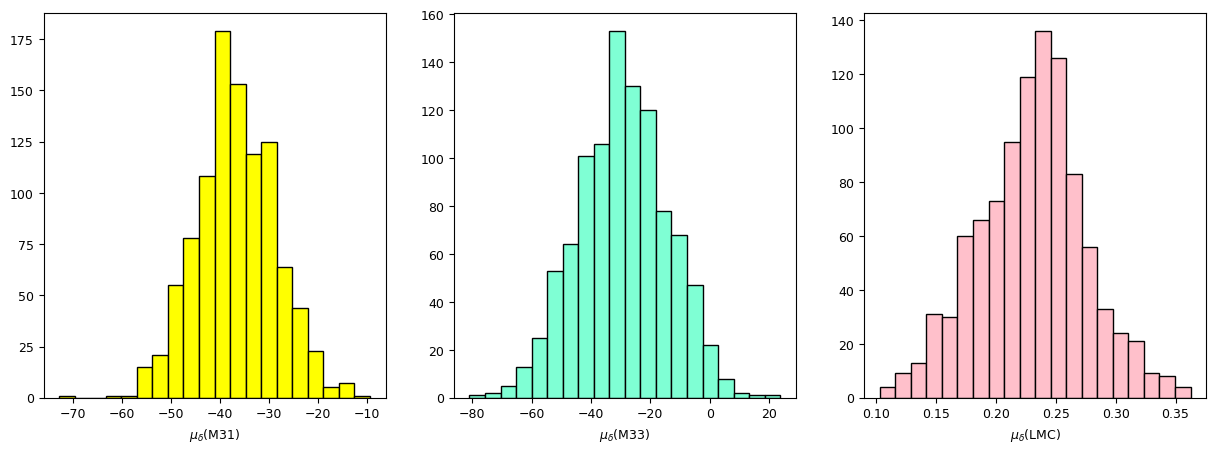

In [182]:
#Pm dec variation

plt.figure(figsize = (15, 5)) 

plt.subplot(1,3,1)
plt.hist(pm_dec_M31.value,color='yellow',ec='black',bins=20)
plt.xlabel('$\mu_{\delta}$(M31)')

stat=statistics(pm_dec_M31)


plt.subplot(1,3,2)
plt.hist(pm_dec_M33.value,color='aquamarine',ec='black',bins=20)
plt.xlabel('$\mu_{\delta}$(M33)')

stat=statistics(pm_dec_M33)

plt.subplot(1,3,3)
plt.hist(pm_dec_LMC.value, color='pink',ec='black',bins=20)
plt.xlabel('$\mu_{\delta}$(LMC)')

stat=statistics(pm_dec_LMC)





-------------------------------------------------------------------------------------------
Variable: dmod_M31
mean= 24.448014207958185
median= 24.447778049909296
standard deviation= 0.09907691300616801
-1 sigma= 0.09676552331585242
1 sigma= 0.1020730722842984
-------------------------------------------------------------------------------------------
Variable: dmod_M33
mean= 24.67314123493325
median= 24.672576245618334
standard deviation= 0.0673445965579477
-1 sigma= 0.06568405561291613
1 sigma= 0.06922448210681864
-------------------------------------------------------------------------------------------
Variable: dmod_LMC
mean= 18.47698260661078
median= 18.47684108873743
standard deviation= 0.026042234824976574
-1 sigma= 0.026583109061256494
1 sigma= 0.02672029247040797


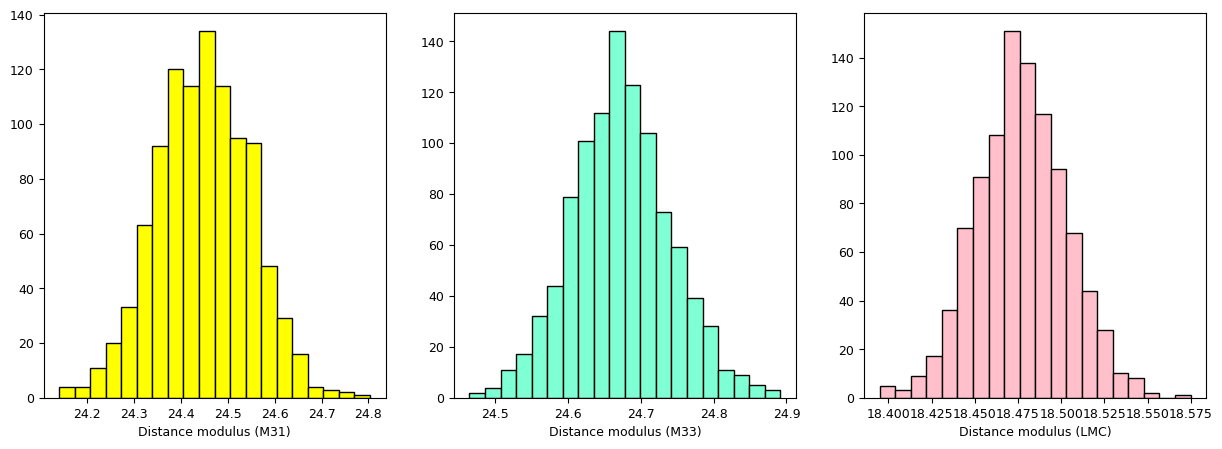

In [183]:
#Distance modulus variation
plt.figure(figsize = (15, 5)) 
plt.subplot(1,3,1)
plt.hist(dmod_M31,color='yellow',ec='black',bins=20)
plt.xlabel('Distance modulus (M31)')

stat=statistics(dmod_M31)


plt.subplot(1,3,2)
plt.hist(dmod_M33,color='aquamarine',ec='black',bins=20)
plt.xlabel('Distance modulus (M33)')

stat=statistics(dmod_M33)

plt.subplot(1,3,3)
plt.hist(dmod_LMC, color='pink',ec='black',bins=20)
plt.xlabel('Distance modulus (LMC)')

stat=statistics(dmod_LMC)


-------------------------------------------------------------------------------------------
Variable: var_v
mean= 142.2707033307982
median= 139.252566905377
standard deviation= 18.16074884511132
-1 sigma= 15.39425626149513
1 sigma= 21.589625690369786
-------------------------------------------------------------------------------------------
Variable: var_vr
mean= -114.41198931684283
median= -114.37707461091084
standard deviation= 1.0219825995110485
-1 sigma= 1.0471514014710408
1 sigma= 0.9799685822830355
-------------------------------------------------------------------------------------------
Variable: var_vt
mean= 80.38685571731563
median= 78.84475511393956
standard deviation= 31.899396622312835
-1 sigma= 31.735919889825453
1 sigma= 34.17611077194651


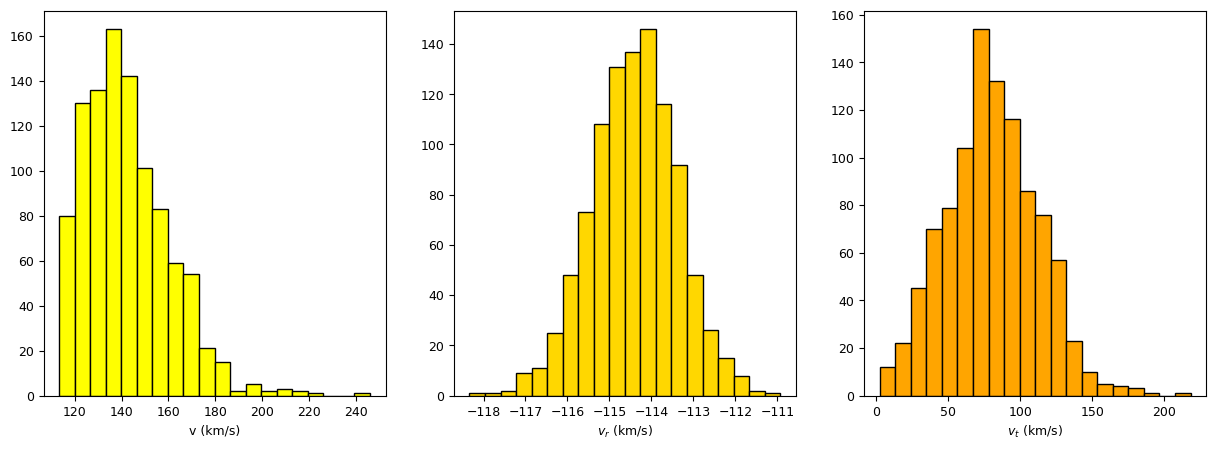

In [190]:
#Velocities variation

plt.figure(figsize = (15, 5)) 
plt.subplot(1,3,1)
plt.hist(var_v,color='yellow',ec='black',bins=20)
plt.xlabel(r'v (km/s)')

stat=statistics(var_v)


plt.subplot(1,3,2)
plt.hist(var_vr,color='gold',ec='black',bins=20)
plt.xlabel(r'$v_r$ (km/s)')

stat=statistics(var_vr)

plt.subplot(1,3,3)
plt.hist(var_vt, color='orange',ec='black',bins=20)
plt.xlabel(r'$v_t$ (km/s)')

stat=statistics(var_vt)

61
-------------------------------------------------------------------------------------------
Variable: var_B
mean= 170.43889032504077
median= 135.02404308372553
standard deviation= 130.23680622410714
-1 sigma= 86.83841766536557
1 sigma= 177.05409905355174


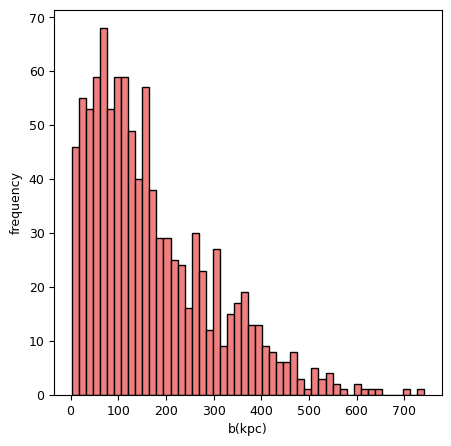

In [185]:
# Impact parameter distribution

plt.figure(figsize = (5, 5)) 

plt.hist(var_B,color='lightcoral',ec='black',bins=50)
plt.ylabel('frequency')
plt.xlabel('b(kpc)')
print(np.argmin(var_B))

statistics(var_B)


-------------------------------------------------------------------------------------------
Variable: var_t
mean= 4.09746598
median= 4.071020000000001
standard deviation= 0.6561977363324561
-1 sigma= 0.5735786400000005
1 sigma= 0.5714947999999991


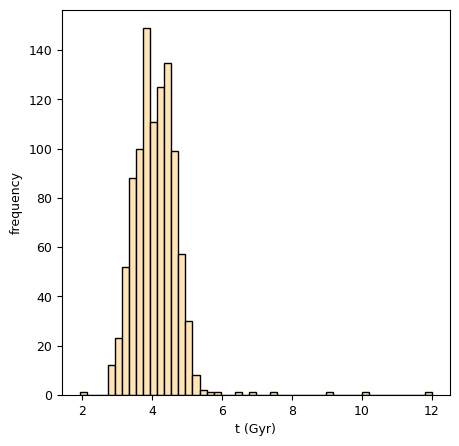

In [186]:
# Time of impact parameter distribution

plt.figure(figsize = (5, 5)) 

plt.hist(var_t,color='moccasin', ec='black', bins=50)

plt.ylabel('frequency')
plt.xlabel('t (Gyr)')

statistics(var_t)


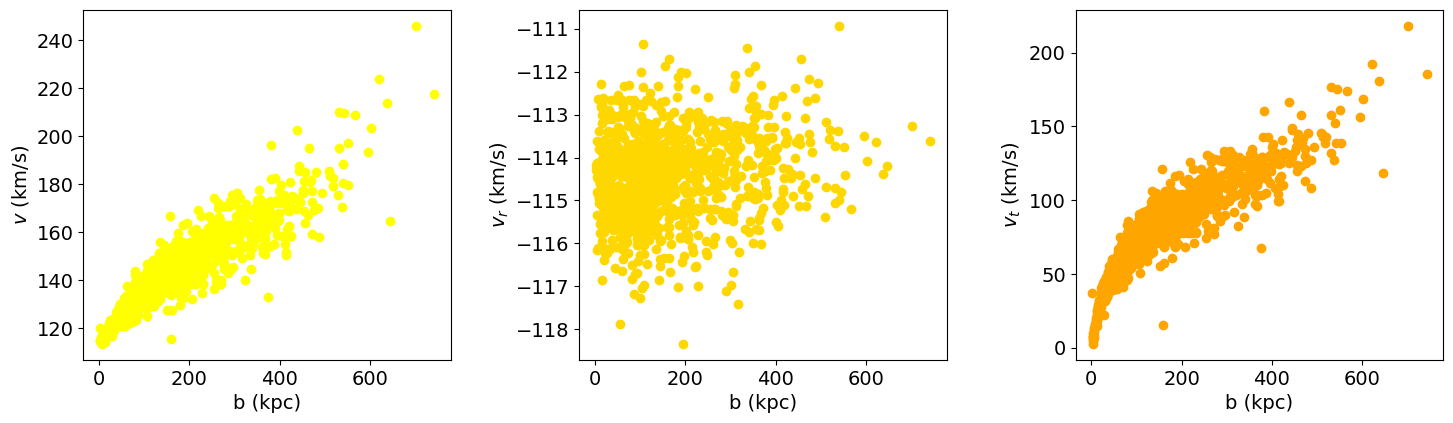

In [194]:
plt.rcParams.update({'font.size':14})

plt.figure(figsize = (17, 5)) 
plt.subplot(1,3,1)
plt.scatter(var_B, var_v,color='yellow')
plt.xlabel('b (kpc)')
plt.ylabel('$v$ (km/s)')




plt.subplot(1,3,2)
plt.scatter(var_B, var_vr,color='gold')
plt.xlabel('b (kpc)')
plt.ylabel('$v_r$ (km/s)')


plt.subplot(1,3,3)

plt.scatter(var_B, var_vt,color='orange')
plt.xlabel('b (kpc)')
plt.ylabel('$v_t$ (km/s)')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.35, hspace=0.35)
